# IMPORTACION DE RECURSOS

In [3]:
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import db_manager
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from tqdm.autonotebook import tqdm
%matplotlib inline
# Silenciar warnings de Prophet durante el fit
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

ModuleNotFoundError: No module named 'statsmodels'

# CONFIGURACIÓN GLOBAL

In [2]:
# Archivos
FILE_NAME = "Datos Históricos de Pedidos y de Facturación.csv"
OUTPUT_FILE_NAME = "Pronostico_Demanda_Top10x5_ENSEMBLE_FINAL.csv"

# Configuración de Análisis
METRIC_COL = 'Pedido_Piezas'
ID_COLS = ['Producto_Descripcion', 'Cliente_Descripcion']
NUM_TOP_PRODUCTS = 10
NUM_TOP_CLIENTS = 5

# Configuración de Modelado
SPLIT_DATE = '2025-01-01'
FORECAST_PERIODS = 12
MIN_DATA_POINTS_FOR_MODELING = 12
COUNTRY_HOLIDAYS = 'MX'

# Configuración de PCA/Clustering
PCA_COMPONENTS = 2
K_CLUSTERS = 4

# Configuración de Modelos
SARIMA_ORDER = (1, 1, 1)
SARIMA_SEASONAL_ORDER = (1, 1, 1, 12)
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 8
RF_FEATURES = ['year', 'month', 'dayofyear', 'is_holiday_month']

# SECCIÓN 1: CARGA Y TRANSFORMACIÓN DE DATOS

In [3]:
try:
    df_raw = pd.read_csv(FILE_NAME)
except Exception as e:
    print(f"Error con encoding por defecto. Intentando 'latin1'...")
    df_raw = pd.read_csv(FILE_NAME, encoding='latin1')

print(f"✓ Datos cargados: {df_raw.shape[0]} filas, {df_raw.shape[1]} columnas")

# Extraer columnas de fechas (Pedido Piezas)
pedido_piezas_cols = df_raw.columns[3:84]

# Filtrar datos relevantes
df_pedidos = df_raw[ID_COLS + list(pedido_piezas_cols)].copy()

# Transformar de formato ancho a largo
df_long = df_pedidos.melt(
    id_vars=ID_COLS,
    value_vars=pedido_piezas_cols,
    var_name='Fecha_str',
    value_name=METRIC_COL
)

# Convertir fechas
try:
    df_long['Fecha'] = pd.to_datetime(df_long['Fecha_str'], format='%y-%b')
except ValueError as e:
    print(f"⚠️ Error convirtiendo fechas: {e}")

# Limpiar DataFrame
df_final = df_long[ID_COLS + ['Fecha', METRIC_COL]].copy()
df_final[METRIC_COL] = df_final[METRIC_COL].fillna(0)

print("✓ Transformación completada (Ancho → Largo)")

✓ Datos cargados: 666 filas, 327 columnas
✓ Transformación completada (Ancho → Largo)


# SECCIÓN 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA)

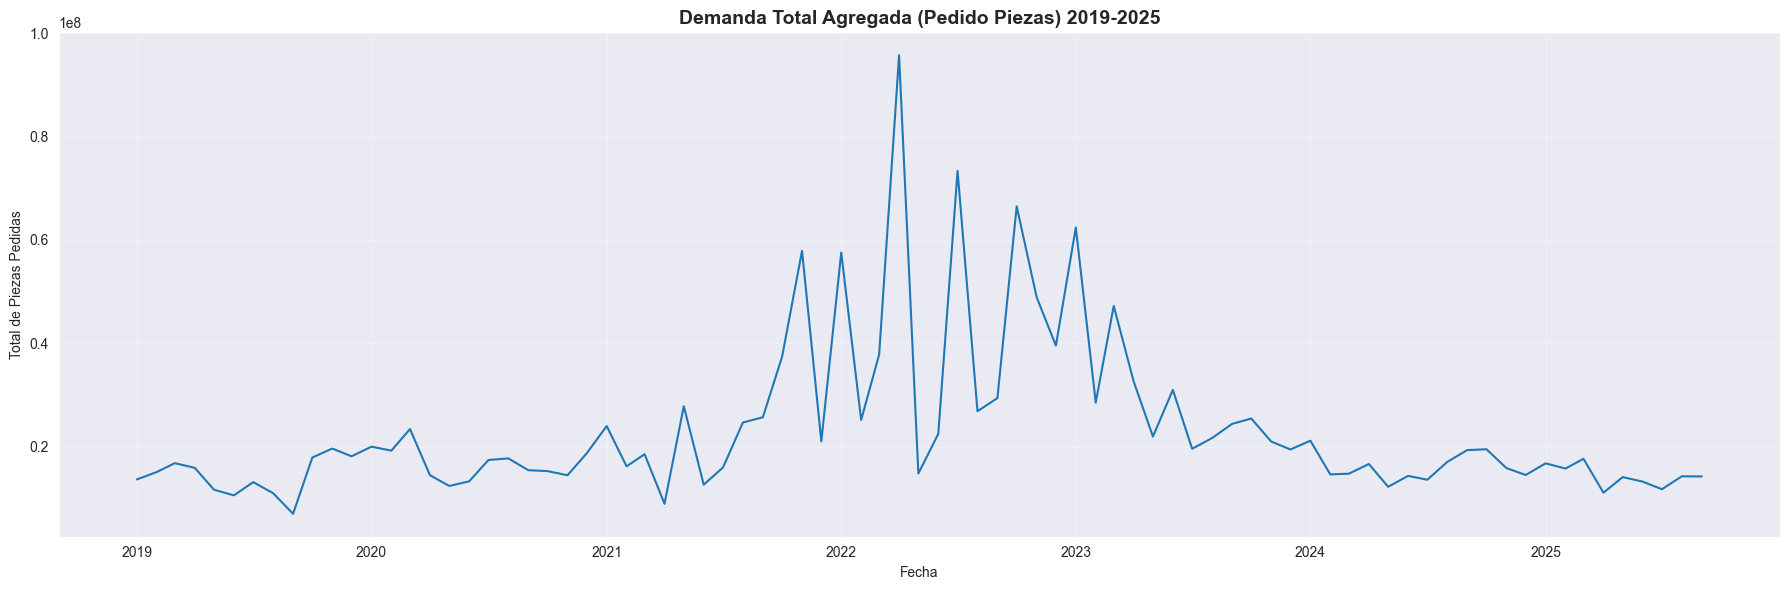


--- Top 10 Productos ---
Producto_Descripcion
ANTIBIOTICO + ANTIFUNGICO CREMA             521680930
ANTIBIOTICO SOLUCIONES INYECTABLE 2         217109895
ANTIPIRETICO SUSPENSION INFANTIL            205972535
ANTIBIOTICO SOLUCIONES INYECTABLE 3         198535220
ANTIBIOTICO SOLUCIONES INYECTABLE ADULTO    150859695
ANALGESICO + ANTIPERETICO TABLETAS 2        107176390
ANALGESICO + ANTIPERETICO TABLETAS 1        101022250
ANTIREUMATOIDE TABLETAS                      76735460
ANTIPIRETICO SOLUCION PEDRIATRICO            70832315
DESCONGESTIONANTE SOLUCION NASAL ADULTO      62867950
Name: Pedido_Piezas, dtype: int64

--- Top 5 Clientes ---
Cliente_Descripcion
Cliente 3        465778950
Cliente 1        409216750
Cliente Otros    271976145
Cliente 2        171057090
Cliente 5        130867555
Name: Pedido_Piezas, dtype: int64


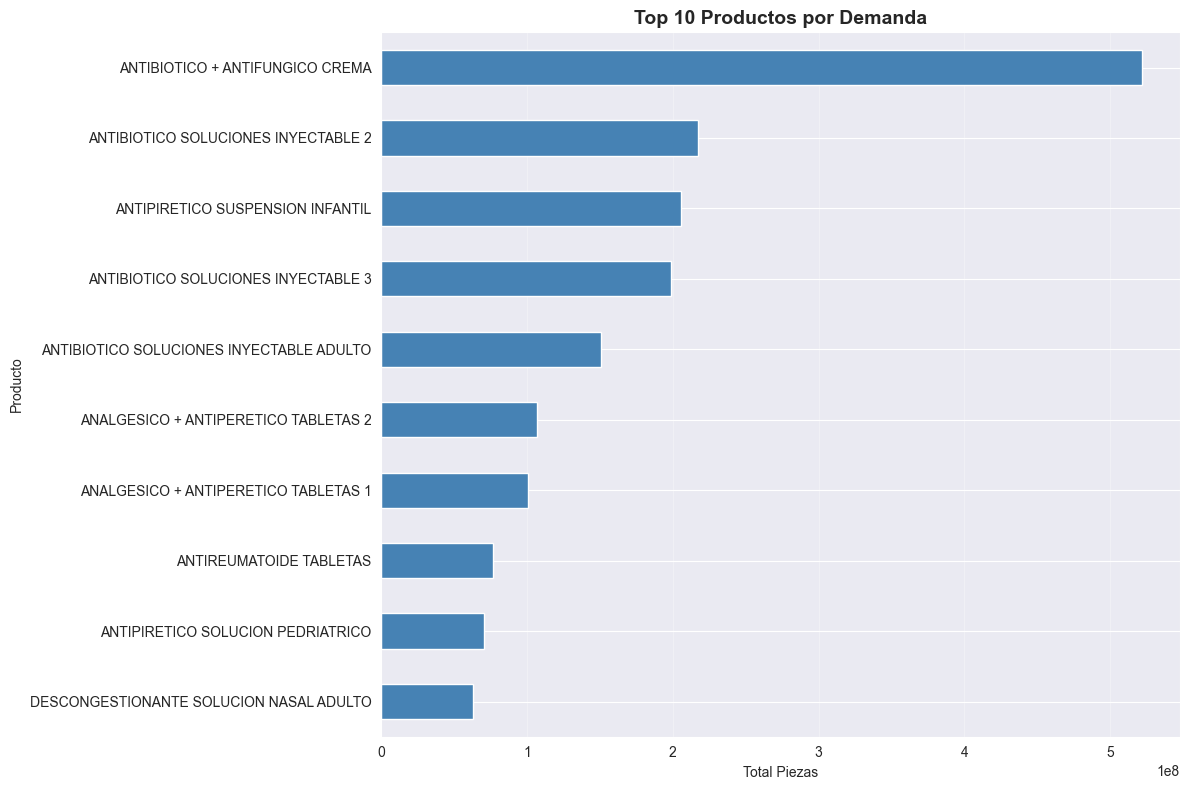

In [4]:
# Agregación total por fecha
df_agregado = df_final.groupby('Fecha')[METRIC_COL].sum().reset_index()

# Gráfico de serie temporal agregada
plt.figure(figsize=(18, 6))
sns.lineplot(data=df_agregado, x='Fecha', y=METRIC_COL)
plt.title('Demanda Total Agregada (Pedido Piezas) 2019-2025', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Total de Piezas Pedidas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identificar Top Productos y Clientes
top_productos = df_final.groupby('Producto_Descripcion')[METRIC_COL].sum().nlargest(NUM_TOP_PRODUCTS)
top_clientes = df_final.groupby('Cliente_Descripcion')[METRIC_COL].sum().nlargest(NUM_TOP_CLIENTS)

print(f"\n--- Top {NUM_TOP_PRODUCTS} Productos ---")
print(top_productos)
print(f"\n--- Top {NUM_TOP_CLIENTS} Clientes ---")
print(top_clientes)

# Visualización de Top Productos
plt.figure(figsize=(12, 8))
top_productos.sort_values().plot(kind='barh', color='steelblue')
plt.title(f'Top {NUM_TOP_PRODUCTS} Productos por Demanda', fontsize=14, fontweight='bold')
plt.xlabel('Total Piezas')
plt.ylabel('Producto')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# SECCIÓN 3: FILTRADO DE DATOS PARA MODELADO

In [1]:
lista_top_productos = top_productos.index
lista_top_clientes = top_clientes.index

df_modelar = df_final[
    (df_final['Producto_Descripcion'].isin(lista_top_productos)) &
    (df_final['Cliente_Descripcion'].isin(lista_top_clientes))
].copy()

df_modelar_agg = df_modelar.groupby(ID_COLS + ['Fecha'])[METRIC_COL].sum().reset_index()

print(f"✓ Datos filtrados: {len(df_modelar_agg)} filas")
print(f"✓ Combinaciones únicas: {df_modelar_agg.groupby(ID_COLS).ngroups}")

# SECCIÓN 4: DESCOMPOSICIÓN DE SERIES TEMPORALES
df_agregado_idx = df_agregado.set_index('Fecha')
decomposition = seasonal_decompose(df_agregado_idx[METRIC_COL], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Descomposición de Serie Temporal (Tendencia, Estacionalidad, Residuos)',
             y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Análisis de estacionalidad
df_agregado['Año'] = df_agregado['Fecha'].dt.year
df_agregado['Mes'] = df_agregado['Fecha'].dt.month_name()

plt.figure(figsize=(14, 6))
meses_ordenados = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
sns.boxplot(data=df_agregado, x='Mes', y=METRIC_COL, order=meses_ordenados)
plt.title('Distribución de Pedidos por Mes (Estacionalidad)', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Piezas Pedidas')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

NameError: name 'top_productos' is not defined

# SECCIÓN 4: PCA Y CLUSTERING

In [1]:
# Crear matriz pivote
df_wide = df_modelar_agg.pivot_table(
    index=ID_COLS,
    columns='Fecha',
    values=METRIC_COL
).fillna(0)

print(f"Matriz PCA: {df_wide.shape[0]} combinaciones x {df_wide.shape[1]} fechas")

if df_wide.shape[0] < 2:
    print("⚠️ ERROR: Necesitas al menos 2 combinaciones para PCA")
else:
    # Escalar datos
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_wide)

    # Aplicar PCA
    pca_model = PCA(n_components=PCA_COMPONENTS)
    principal_components = pca_model.fit_transform(data_scaled)

    # DataFrame de componentes principales
    column_names = [f'PC{i+1}' for i in range(PCA_COMPONENTS)]
    df_pca = pd.DataFrame(
        data=principal_components,
        columns=column_names,
        index=df_wide.index
    ).reset_index()

    variance_explained = pca_model.explained_variance_ratio_
    var_pc1 = variance_explained[0]
    var_pc2 = variance_explained[1] if PCA_COMPONENTS > 1 else 0

    print(f"✓ PCA completado. Varianza explicada: PC1={var_pc1:.1%}, PC2={var_pc2:.1%}")

    # Visualizar PCA
    if PCA_COMPONENTS >= 2:
        plt.figure(figsize=(14, 10))
        scatter = sns.scatterplot(
            data=df_pca,
            x='PC1',
            y='PC2',
            hue='Cliente_Descripcion',
            style='Producto_Descripcion',
            s=200,
            alpha=0.7,
            palette='tab10'
        )
        plt.title('Análisis de Componentes Principales (PCA)', fontsize=16, fontweight='bold')
        plt.xlabel(f'PC1 ({var_pc1:.1%} de varianza)', fontsize=12)
        plt.ylabel(f'PC2 ({var_pc2:.1%} de varianza)', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # K-Means Clustering - Metodo del Codo
    df_pca_cluster = df_pca[['PC1', 'PC2']].copy()
    sse = []
    k_range = range(1, 11)

    for k in k_range:
        kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans_model.fit(df_pca_cluster)
        sse.append(kmeans_model.inertia_)

    # Gráfico del codo
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o', linestyle='--', linewidth=2, markersize=8)
    plt.axvline(x=K_CLUSTERS, color='r', linestyle='--', linewidth=2, label=f'K Seleccionado: {K_CLUSTERS}')
    plt.title('Método del Codo para Determinar K Óptimo', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Suma de Errores Cuadráticos (SSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Aplicar K-Means final
    kmeans_final = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
    df_pca['Cluster'] = kmeans_final.fit_predict(df_pca_cluster)

    # Visualizar clusters
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=df_pca,
        x='PC1',
        y='PC2',
        hue='Cluster',
        style='Producto_Descripcion',
        palette='deep',
        s=200,
        alpha=0.7
    )
    centers = kmeans_final.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, marker='X',
                edgecolors='white', linewidths=2, label='Centroides')
    plt.title(f'Clusters de Patrones de Demanda (K={K_CLUSTERS})', fontsize=16, fontweight='bold')
    plt.xlabel(f'PC1 ({var_pc1:.1%} varianza)')
    plt.ylabel(f'PC2 ({var_pc2:.1%} varianza)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n--- Distribución por Cluster ---")
    print(df_pca['Cluster'].value_counts().sort_index())
    print("\n--- Características Promedio por Cluster ---")
    print(df_pca.groupby('Cluster')[['PC1', 'PC2']].mean())

NameError: name 'df_modelar_agg' is not defined

# SECCIÓN 5: PREPARACIÓN DE DATOS PARA MODELADO

In [7]:
# Verificar que hay datos para modelar
combinaciones = df_modelar_agg[ID_COLS].drop_duplicates()

if len(combinaciones) == 0:
    print("⚠️ ERROR: No hay combinaciones disponibles para modelar")
else:
    # Seleccionar una serie de ejemplo para pruebas
    prod_ejemplo, cliente_ejemplo = combinaciones.iloc[0][ID_COLS[0]], combinaciones.iloc[0][ID_COLS[1]]

    print(f"Serie de ejemplo: {prod_ejemplo} | {cliente_ejemplo}")

    df_serie_unica = df_modelar_agg[
        (df_modelar_agg['Producto_Descripcion'] == prod_ejemplo) &
        (df_modelar_agg['Cliente_Descripcion'] == cliente_ejemplo)
    ]

    # Preparar para Prophet
    df_prophet = df_serie_unica[['Fecha', METRIC_COL]].rename(
        columns={'Fecha': 'ds', METRIC_COL: 'y'}
    )

    # División Train/Test
    df_train = df_prophet[df_prophet['ds'] < SPLIT_DATE]
    df_test = df_prophet[df_prophet['ds'] >= SPLIT_DATE]

    print(f"✓ Entrenamiento: {len(df_train)} meses | Prueba: {len(df_test)} meses")

# Definir y_true_test (se usa en todos los modelos)
y_true_test = df_test['y'].values

Serie de ejemplo: ANALGESICO + ANTIPERETICO TABLETAS 1 | Cliente 1
✓ Entrenamiento: 72 meses | Prueba: 9 meses


# SECCIÓN 6: MODELADO INDIVIDUAL - PROPHET

16:02:47 - cmdstanpy - INFO - Chain [1] start processing
16:02:48 - cmdstanpy - INFO - Chain [1] done processing


✓ RMSE Prophet: 156091.14


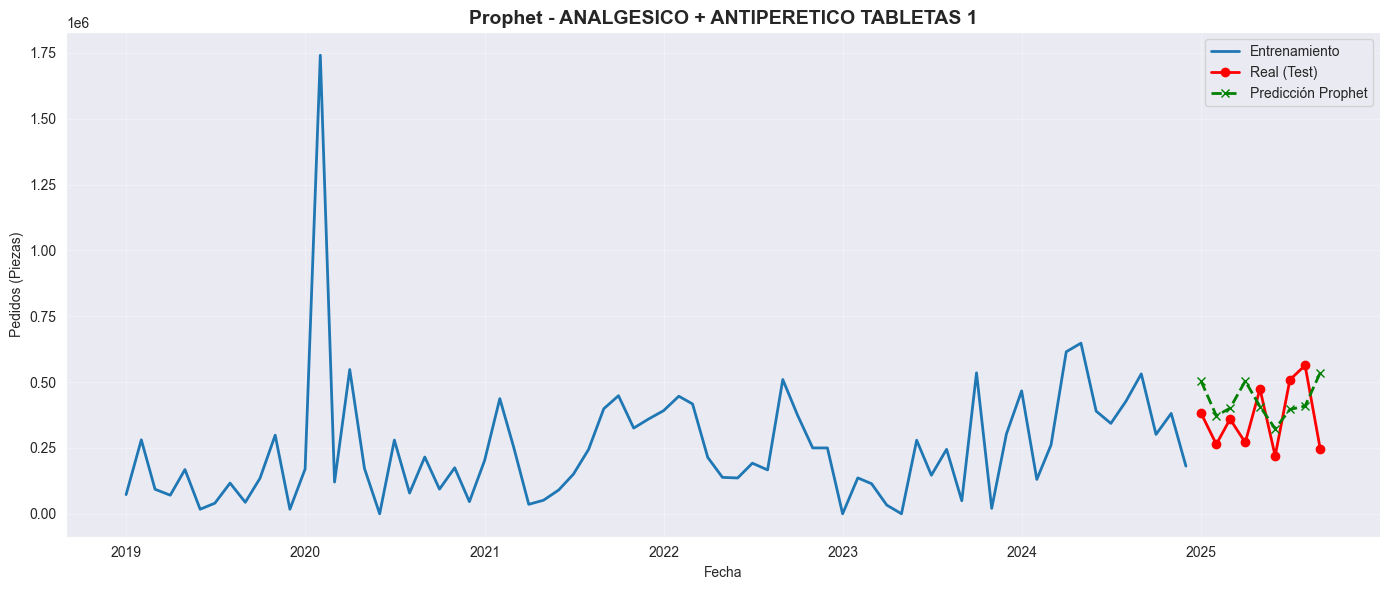

In [8]:
try:
  m_prophet = Prophet(
      changepoint_prior_scale=0.5,
      seasonality_mode='additive',
      seasonality_prior_scale=10.0
  )
  if COUNTRY_HOLIDAYS:
      m_prophet.add_country_holidays(country_name=COUNTRY_HOLIDAYS)
      m_prophet.fit(df_train)

      # Predicción en test
      future_prophet = pd.DataFrame({'ds': df_test['ds']})
      forecast_prophet = m_prophet.predict(future_prophet)
      y_pred_prophet_test = forecast_prophet['yhat'].values

      rmse_prophet = np.sqrt(mean_squared_error(y_true_test, y_pred_prophet_test))

      print(f"✓ RMSE Prophet: {rmse_prophet:.2f}")

        # Visualización
      plt.figure(figsize=(14, 6))
      plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', linewidth=2)
      plt.plot(df_test['ds'], df_test['y'], label='Real (Test)', color='red', marker='o', linewidth=2)
      plt.plot(df_test['ds'], y_pred_prophet_test, label='Predicción Prophet',
                color='green', linestyle='--', marker='x', linewidth=2)
      plt.title(f'Prophet - {prod_ejemplo}', fontsize=14, fontweight='bold')
      plt.xlabel('Fecha')
      plt.ylabel('Pedidos (Piezas)')
      plt.legend()
      plt.grid(True, alpha=0.3)
      plt.tight_layout()
      plt.show()
except Exception as e:
        print(f"⚠️ Error en Prophet: {e}")
        y_pred_prophet_test = np.full(len(df_test), np.nan)
        rmse_prophet = np.nan

# SECCIÓN 7: MODELADO INDIVIDUAL - SARIMA

✓ RMSE SARIMA: 119766.63


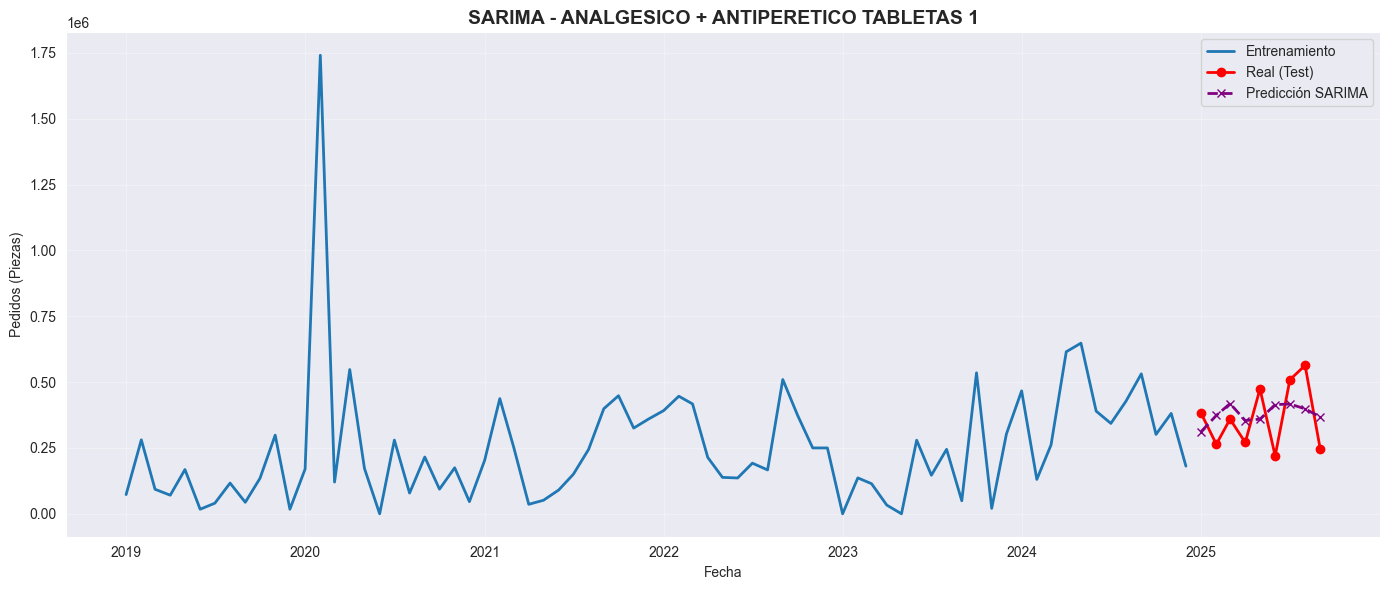

In [9]:
try:
    df_train_indexed = df_train.set_index('ds')
    df_train_indexed.index = pd.to_datetime(df_train_indexed.index)
    df_train_indexed = df_train_indexed.asfreq('MS')

    arima_model = SARIMAX(
        df_train_indexed['y'],
        order=SARIMA_ORDER,
        seasonal_order=SARIMA_SEASONAL_ORDER,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    arima_results = arima_model.fit(disp=False)

    # Predicción
    start_date = df_test['ds'].min()
    end_date = df_test['ds'].max()
    predictions_sarima = arima_results.predict(start=start_date, end=end_date, dynamic=False)
    y_pred_sarima_test = predictions_sarima.values

    rmse_sarima = np.sqrt(mean_squared_error(y_true_test, y_pred_sarima_test))

    print(f"✓ RMSE SARIMA: {rmse_sarima:.2f}")

    # Visualización
    plt.figure(figsize=(14, 6))
    plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', linewidth=2)
    plt.plot(df_test['ds'], df_test['y'], label='Real (Test)', color='red', marker='o', linewidth=2)
    plt.plot(df_test['ds'], y_pred_sarima_test, label='Predicción SARIMA',
              color='purple', linestyle='--', marker='x', linewidth=2)
    plt.title(f'SARIMA - {prod_ejemplo}', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Pedidos (Piezas)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Error en SARIMA: {e}")
    y_pred_sarima_test = np.full(len(df_test), np.nan)
    rmse_sarima = np.nan

# SECCIÓN 8: MODELADO INDIVIDUAL - RANDOM FOREST

✓ RMSE Random Forest: 148898.06

--- Importancia de Características ---
year                0.501534
dayofyear           0.287322
month               0.179058
is_holiday_month    0.032086
dtype: float64


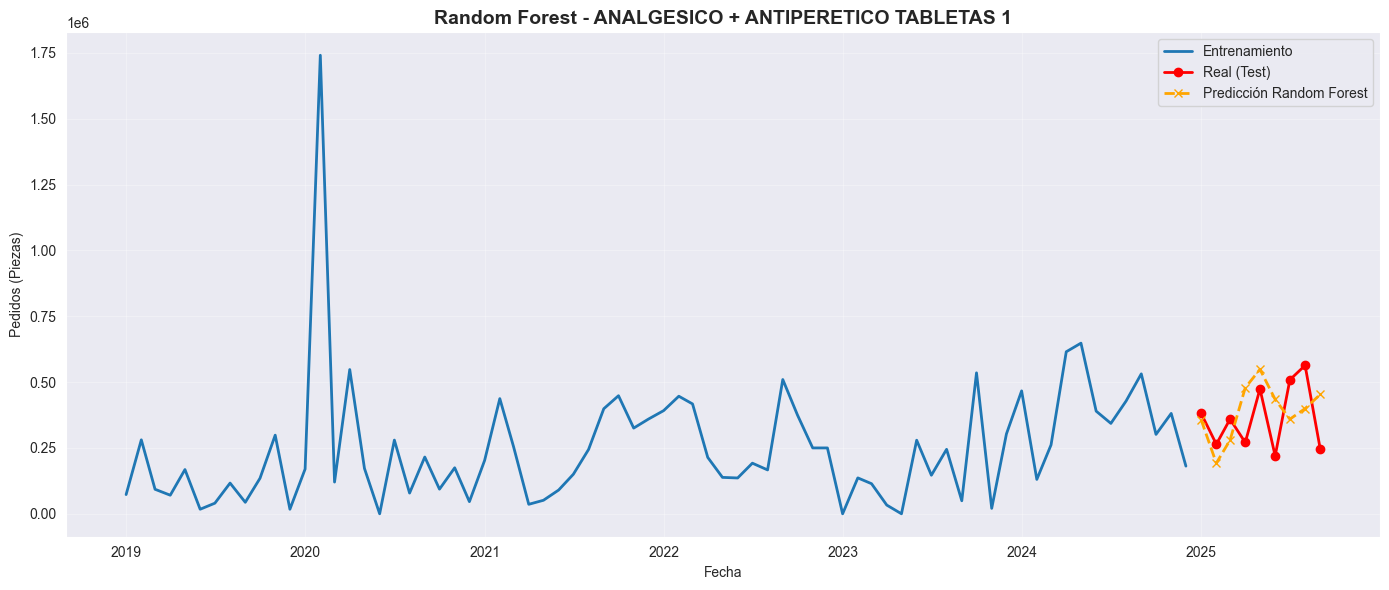

In [10]:
def create_time_features(df):
    df = df.copy()
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month
    df['dayofyear'] = df['ds'].dt.dayofyear
    return df

def create_holiday_features(df, country, years):
    df = df.copy()
    if country:
        holidays = make_holidays_df(year_list=years, country=country)
        holiday_months = holidays['ds'].dt.to_period('M').unique()
        df['is_holiday_month'] = df['ds'].dt.to_period('M').isin(holiday_months).astype(int)
    else:
        df['is_holiday_month'] = 0
    return df
try:
    df_train_ml = create_time_features(df_train.copy())
    df_test_ml = create_time_features(df_test.copy())

    all_years = pd.concat([df_train_ml['ds'], df_test_ml['ds']]).dt.year.unique()
    df_train_ml = create_holiday_features(df_train_ml, COUNTRY_HOLIDAYS, all_years)
    df_test_ml = create_holiday_features(df_test_ml, COUNTRY_HOLIDAYS, all_years)

    X_train = df_train_ml[RF_FEATURES]
    y_train = df_train_ml['y']
    X_test = df_test_ml[RF_FEATURES]
    y_test_ml = df_test_ml['y']

    ml_model = RandomForestRegressor(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=42,
        n_jobs=-1
    )
    ml_model.fit(X_train, y_train)

    y_pred_rf_test = ml_model.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test_ml, y_pred_rf_test))

    print(f"✓ RMSE Random Forest: {rmse_rf:.2f}")

    # Importancia de características
    feature_importance = pd.Series(ml_model.feature_importances_, index=RF_FEATURES).sort_values(ascending=False)
    print("\n--- Importancia de Características ---")
    print(feature_importance)

    # Visualización
    plt.figure(figsize=(14, 6))
    plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', linewidth=2)
    plt.plot(df_test['ds'], y_test_ml, label='Real (Test)', color='red', marker='o', linewidth=2)
    plt.plot(df_test['ds'], y_pred_rf_test, label='Predicción Random Forest',
              color='orange', linestyle='--', marker='x', linewidth=2)
    plt.title(f'Random Forest - {prod_ejemplo}', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Pedidos (Piezas)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Error en Random Forest: {e}")
    y_pred_rf_test = np.full(len(df_test), np.nan)
    rmse_rf = np.nan

# SECCIÓN 9: COMPARACIÓN DE MODELOS Y ENSEMBLE POR PROMEDIO SIMPLE

✓ RMSE Ensemble: 127591.48

--- Comparación Final ---
             Modelo          RMSE
             SARIMA 119766.632721
Ensemble (Promedio) 127591.477107
      Random Forest 148898.064638
            Prophet 156091.135214


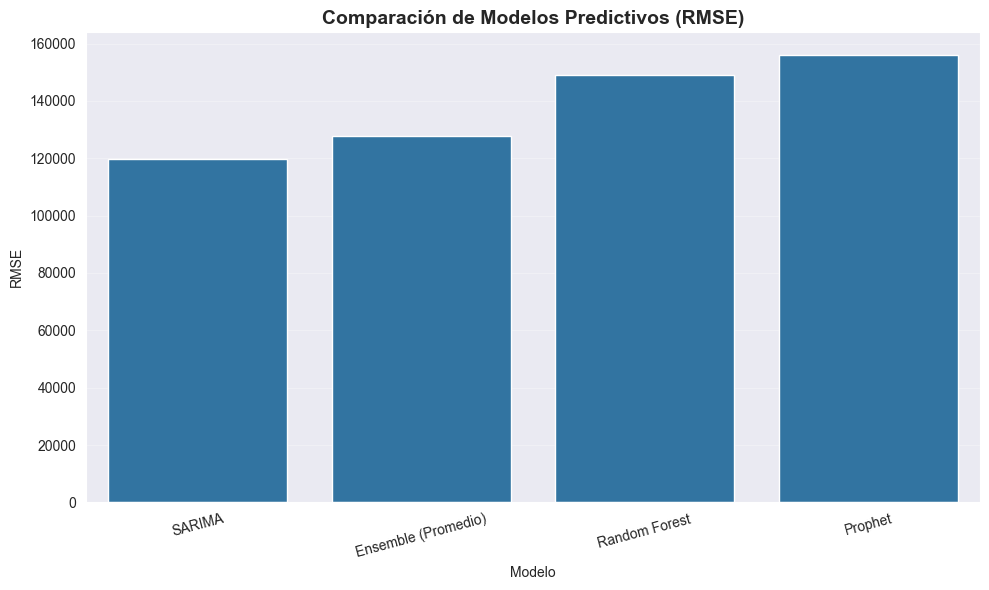

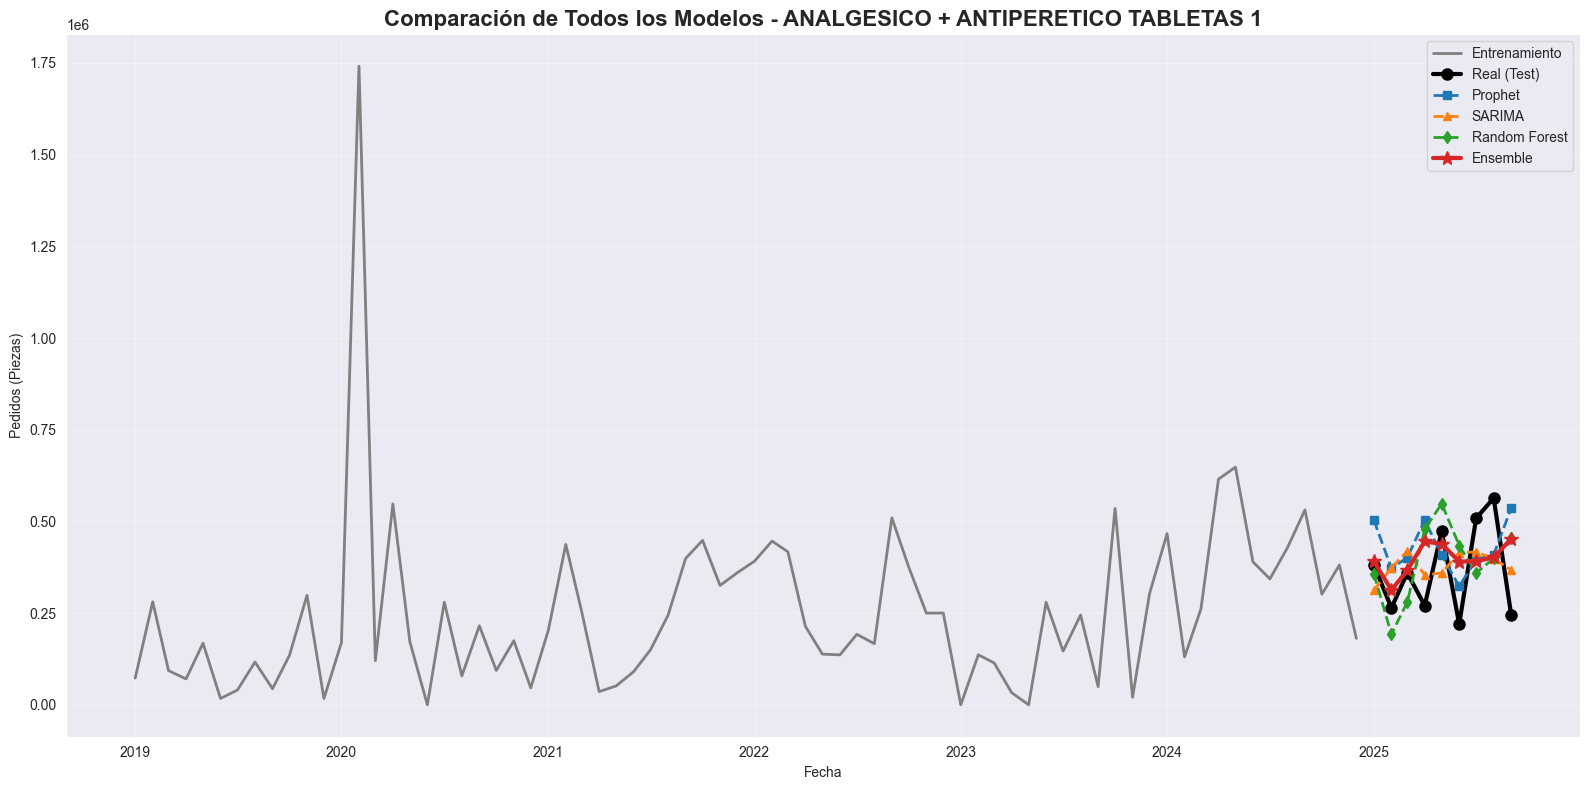

In [11]:
y_pred_ensemble = np.nanmean([y_pred_rf_test, y_pred_prophet_test, y_pred_sarima_test], axis=0)
rmse_ensemble = np.sqrt(mean_squared_error(y_true_test, y_pred_ensemble))

print(f"✓ RMSE Ensemble: {rmse_ensemble:.2f}")

# Tabla de comparación
df_comparacion = pd.DataFrame({
    'Modelo': ['Random Forest', 'SARIMA', 'Prophet', 'Ensemble (Promedio)'],
    'RMSE': [rmse_rf, rmse_sarima, rmse_prophet, rmse_ensemble]
}).sort_values(by='RMSE')

print("\n--- Comparación Final ---")
print(df_comparacion.to_string(index=False))

# Visualización comparativa
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comparacion, x='Modelo', y='RMSE')
plt.title('Comparación de Modelos Predictivos (RMSE)', fontsize=14, fontweight='bold')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Visualización de todas las predicciones
plt.figure(figsize=(16, 8))
plt.plot(df_train['ds'], df_train['y'], label='Entrenamiento', linewidth=2, color='gray')
plt.plot(df_test['ds'], y_true_test, label='Real (Test)', color='black', marker='o', linewidth=3, markersize=8)
plt.plot(df_test['ds'], y_pred_prophet_test, label='Prophet', linestyle='--', marker='s', linewidth=2)
plt.plot(df_test['ds'], y_pred_sarima_test, label='SARIMA', linestyle='--', marker='^', linewidth=2)
plt.plot(df_test['ds'], y_pred_rf_test, label='Random Forest', linestyle='--', marker='d', linewidth=2)
plt.plot(df_test['ds'], y_pred_ensemble, label='Ensemble', linestyle='-', marker='*', linewidth=3, markersize=10)
plt.title(f'Comparación de Todos los Modelos - {prod_ejemplo}', fontsize=16, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Pedidos (Piezas)')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# SECCIÓN 10: MODELADO ENSEMBLE POR LOTES

In [12]:
lista_pronosticos = []
total_combinaciones = len(combinaciones)

for idx, row in combinaciones.iterrows():
    producto = row['Producto_Descripcion']
    cliente = row['Cliente_Descripcion']

    # Aislar serie
    df_serie = df_modelar_agg[
        (df_modelar_agg['Producto_Descripcion'] == producto) &
        (df_modelar_agg['Cliente_Descripcion'] == cliente)
    ]

    df_prophet_prep = df_serie[['Fecha', METRIC_COL]].rename(columns={'Fecha': 'ds', METRIC_COL: 'y'})

    # Control de calidad
    if df_prophet_prep[df_prophet_prep['y'] > 0].shape[0] < MIN_DATA_POINTS_FOR_MODELING:
        print(f"  ⊗ OMITIDO (datos insuficientes): {producto} | {cliente}")
        continue

    df_train_full = df_prophet_prep.copy()

    # Crear fechas futuras
    last_date = df_train_full['ds'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=FORECAST_PERIODS, freq='MS')
    future_df = pd.DataFrame({'ds': future_dates})

    # Prophet
    try:
        m = Prophet(seasonality_mode='additive')
        if COUNTRY_HOLIDAYS:
            m.add_country_holidays(country_name=COUNTRY_HOLIDAYS)
        m.fit(df_train_full)
        forecast_p = m.predict(future_df)
        yhat_p = forecast_p['yhat'].values
    except:
        yhat_p = np.full(FORECAST_PERIODS, np.nan)

    # Random Forest
    try:
        df_train_rf = create_time_features(df_train_full.copy())
        df_future_rf = create_time_features(future_df.copy())

        all_yrs = pd.concat([df_train_rf['ds'], df_future_rf['ds']]).dt.year.unique()
        df_train_rf = create_holiday_features(df_train_rf, COUNTRY_HOLIDAYS, all_yrs)
        df_future_rf = create_holiday_features(df_future_rf, COUNTRY_HOLIDAYS, all_yrs)

        rf = RandomForestRegressor(n_estimators=RF_N_ESTIMATORS, max_depth=RF_MAX_DEPTH, random_state=42, n_jobs=-1)
        rf.fit(df_train_rf[RF_FEATURES], df_train_rf['y'])
        yhat_rf = rf.predict(df_future_rf[RF_FEATURES])
    except:
        yhat_rf = np.full(FORECAST_PERIODS, np.nan)

    # SARIMA
    try:
        df_train_idx = df_train_full.set_index('ds')
        df_train_idx = df_train_idx.asfreq('MS')

        sarima = SARIMAX(df_train_idx['y'], order=SARIMA_ORDER,
                        seasonal_order=SARIMA_SEASONAL_ORDER,
                        enforce_stationarity=False, enforce_invertibility=False)
        sarima_fit = sarima.fit(disp=False)
        forecast_s = sarima_fit.get_forecast(steps=FORECAST_PERIODS)
        yhat_s = forecast_s.predicted_mean.values
    except:
        yhat_s = np.full(FORECAST_PERIODS, np.nan)

    # Ensemble (promedio)
    yhat_ensemble = np.nanmean([yhat_p, yhat_rf, yhat_s], axis=0)

    # Usar intervalos de Prophet (simplificación)
    try:
        yhat_min = forecast_p['yhat_lower'].values
        yhat_max = forecast_p['yhat_upper'].values
    except:
        yhat_min = yhat_ensemble * 0.8
        yhat_max = yhat_ensemble * 1.2

    # Consolidar resultado
    pronostico = pd.DataFrame({
        'ds': future_dates,
        'yhat': yhat_ensemble,
        'yhat_lower': yhat_min,
        'yhat_upper': yhat_max,
        'Producto_Descripcion': producto,
        'Cliente_Descripcion': cliente
    })

    lista_pronosticos.append(pronostico)

    if (idx + 1) % 5 == 0 or (idx + 1) == total_combinaciones:
        print(f"  ✓ Progreso: {idx + 1}/{total_combinaciones} combinaciones procesadas")

16:02:52 - cmdstanpy - INFO - Chain [1] start processing
16:02:53 - cmdstanpy - INFO - Chain [1] done processing
16:02:54 - cmdstanpy - INFO - Chain [1] start processing
16:02:54 - cmdstanpy - INFO - Chain [1] done processing
16:02:55 - cmdstanpy - INFO - Chain [1] start processing
16:02:55 - cmdstanpy - INFO - Chain [1] done processing
16:02:56 - cmdstanpy - INFO - Chain [1] start processing
16:02:57 - cmdstanpy - INFO - Chain [1] done processing
16:02:58 - cmdstanpy - INFO - Chain [1] start processing
16:02:59 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 325/50 combinaciones procesadas


16:03:00 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] done processing
16:03:02 - cmdstanpy - INFO - Chain [1] start processing
16:03:03 - cmdstanpy - INFO - Chain [1] done processing
16:03:04 - cmdstanpy - INFO - Chain [1] start processing
16:03:05 - cmdstanpy - INFO - Chain [1] done processing
16:03:06 - cmdstanpy - INFO - Chain [1] start processing
16:03:06 - cmdstanpy - INFO - Chain [1] done processing
16:03:08 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 730/50 combinaciones procesadas


16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing
16:03:12 - cmdstanpy - INFO - Chain [1] start processing
16:03:14 - cmdstanpy - INFO - Chain [1] done processing
16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing
16:03:17 - cmdstanpy - INFO - Chain [1] start processing
16:03:17 - cmdstanpy - INFO - Chain [1] done processing
16:03:19 - cmdstanpy - INFO - Chain [1] start processing
16:03:19 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 1135/50 combinaciones procesadas


16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing
16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing
16:03:24 - cmdstanpy - INFO - Chain [1] start processing
16:03:25 - cmdstanpy - INFO - Chain [1] done processing
16:03:26 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing
16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:29 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 1540/50 combinaciones procesadas


16:03:30 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing
16:03:32 - cmdstanpy - INFO - Chain [1] start processing
16:03:33 - cmdstanpy - INFO - Chain [1] done processing
16:03:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1] done processing
16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:37 - cmdstanpy - INFO - Chain [1] done processing
16:03:38 - cmdstanpy - INFO - Chain [1] start processing
16:03:39 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 1945/50 combinaciones procesadas


16:03:40 - cmdstanpy - INFO - Chain [1] start processing
16:03:41 - cmdstanpy - INFO - Chain [1] done processing
16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing
16:03:44 - cmdstanpy - INFO - Chain [1] start processing
16:03:45 - cmdstanpy - INFO - Chain [1] done processing
16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing
16:03:48 - cmdstanpy - INFO - Chain [1] start processing
16:03:48 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 2350/50 combinaciones procesadas


16:03:49 - cmdstanpy - INFO - Chain [1] start processing
16:03:50 - cmdstanpy - INFO - Chain [1] done processing
16:03:51 - cmdstanpy - INFO - Chain [1] start processing
16:03:52 - cmdstanpy - INFO - Chain [1] done processing
16:03:53 - cmdstanpy - INFO - Chain [1] start processing
16:03:54 - cmdstanpy - INFO - Chain [1] done processing
16:03:55 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing
16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 2755/50 combinaciones procesadas


16:03:59 - cmdstanpy - INFO - Chain [1] start processing
16:04:00 - cmdstanpy - INFO - Chain [1] done processing
16:04:01 - cmdstanpy - INFO - Chain [1] start processing
16:04:02 - cmdstanpy - INFO - Chain [1] done processing
16:04:03 - cmdstanpy - INFO - Chain [1] start processing
16:04:03 - cmdstanpy - INFO - Chain [1] done processing
16:04:04 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing
16:04:06 - cmdstanpy - INFO - Chain [1] start processing
16:04:07 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 3160/50 combinaciones procesadas


16:04:08 - cmdstanpy - INFO - Chain [1] start processing
16:04:08 - cmdstanpy - INFO - Chain [1] done processing
16:04:09 - cmdstanpy - INFO - Chain [1] start processing
16:04:10 - cmdstanpy - INFO - Chain [1] done processing
16:04:11 - cmdstanpy - INFO - Chain [1] start processing
16:04:11 - cmdstanpy - INFO - Chain [1] done processing
16:04:12 - cmdstanpy - INFO - Chain [1] start processing
16:04:13 - cmdstanpy - INFO - Chain [1] done processing
16:04:14 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 3565/50 combinaciones procesadas


16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:19 - cmdstanpy - INFO - Chain [1] done processing
16:04:22 - cmdstanpy - INFO - Chain [1] start processing
16:04:22 - cmdstanpy - INFO - Chain [1] done processing
16:04:24 - cmdstanpy - INFO - Chain [1] start processing
16:04:25 - cmdstanpy - INFO - Chain [1] done processing
16:04:26 - cmdstanpy - INFO - Chain [1] start processing
16:04:26 - cmdstanpy - INFO - Chain [1] done processing
16:04:27 - cmdstanpy - INFO - Chain [1] start processing
16:04:28 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Progreso: 3970/50 combinaciones procesadas


# SECCIÓN 11: CONSOLIDACIÓN Y EXPORTACIÓN


 PRONÓSTICO MAESTRO GENERADO EXITOSAMENTE

Total de registros generados: 600

Primeras filas:
                   Producto_Descripcion Cliente_Descripcion  Cluster  \
0  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
1  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
2  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
3  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
4  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
5  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
6  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
7  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
8  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   
9  ANALGESICO + ANTIPERETICO TABLETAS 1           Cliente 1        0   

  Fecha_Pronostico  Pronostico_Ensemble_PedidoPiezas  Pronostico_Min  \
0       2025-10-01                     3

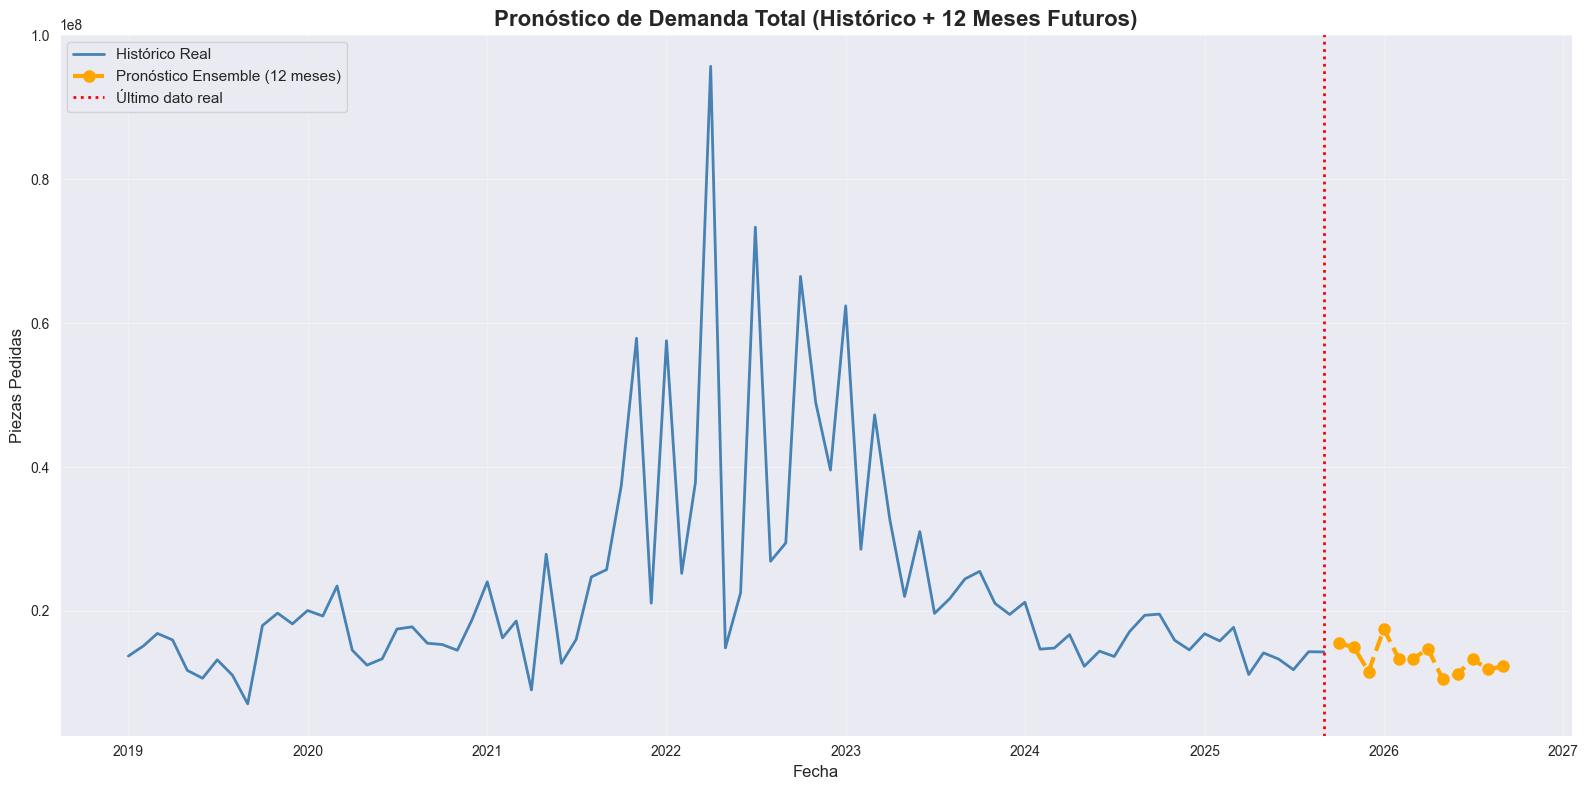

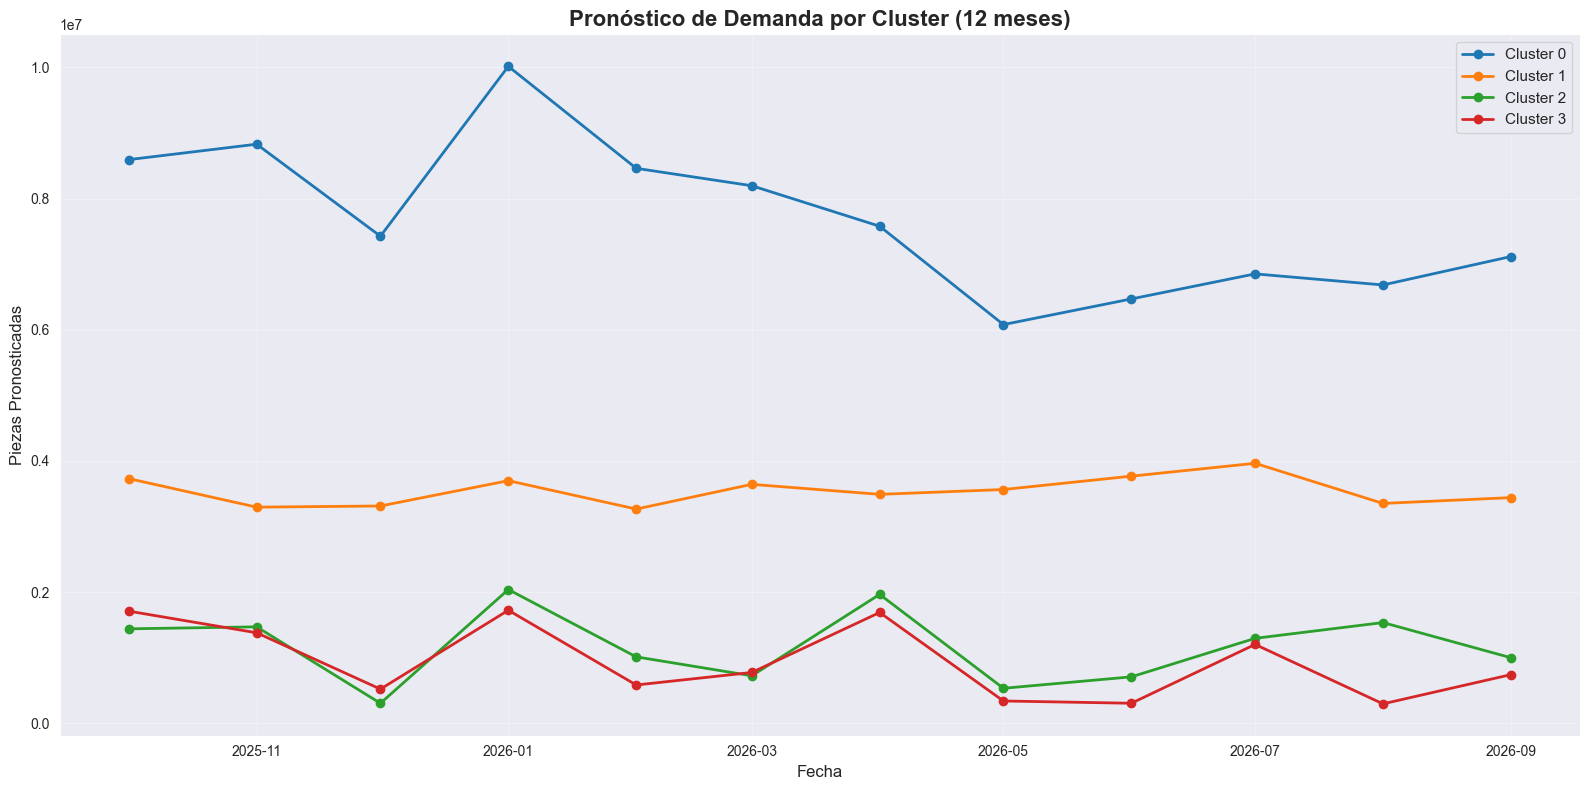

In [13]:
# Verificar si se generaron pronósticos en el bucle anterior
if lista_pronosticos:
    # 1. CONSOLIDACIÓN
    # ---------------------------------------------------------
    df_pronostico_maestro = pd.concat(lista_pronosticos, ignore_index=True)

    # Fusionar con la información de Clusters (del paso de PCA/K-Means)
    # Esto es crucial para los filtros del Dashboard
    df_cluster_map = df_pca[ID_COLS + ['Cluster']].copy()

    df_pronostico_maestro = pd.merge(
        df_pronostico_maestro,
        df_cluster_map,
        on=ID_COLS,
        how='left'
    )

    # 2. LIMPIEZA Y RENOMBRAMIENTO
    # ---------------------------------------------------------
    METRIC_CLEAN = METRIC_COL.replace("_", "")

    # Renombrar columnas técnicas a nombres de negocio
    df_pronostico_maestro = df_pronostico_maestro.rename(columns={
        'ds': 'Fecha_Pronostico',
        'yhat': f'Pronostico_Ensemble_{METRIC_CLEAN}',
        'yhat_lower': 'Pronostico_Min',
        'yhat_upper': 'Pronostico_Max'
    })

    # Definir orden final de columnas
    columnas_finales = [
        'Producto_Descripcion',
        'Cliente_Descripcion',
        'Cluster',
        'Fecha_Pronostico',
        f'Pronostico_Ensemble_{METRIC_CLEAN}',
        'Pronostico_Min',
        'Pronostico_Max'
    ]

    # Filtrar el DataFrame final
    df_pronostico_maestro = df_pronostico_maestro[columnas_finales]

    print("\n" + "="*80)
    print(" PRONÓSTICO MAESTRO GENERADO EXITOSAMENTE")
    print("="*80)
    print(f"\nTotal de registros generados: {len(df_pronostico_maestro)}")
    print(f"\nPrimeras filas:")
    print(df_pronostico_maestro.head(10))

    # Resumen rápido por cluster para control de calidad
    pronostico_col = f'Pronostico_Ensemble_{METRIC_CLEAN}'
    resumen_cluster = df_pronostico_maestro.groupby('Cluster')[pronostico_col].sum().reset_index()
    resumen_cluster = resumen_cluster.rename(columns={pronostico_col: 'Suma_Pronostico_Total'})

    print("\n--- Resumen por Cluster ---")
    print(resumen_cluster)
    print(f"\n Suma Total Global Pronosticada: {resumen_cluster['Suma_Pronostico_Total'].sum():,.0f}")

    # 3. EXPORTACIÓN A BASE DE DATOS SQL (AUTOMATIZACIÓN)
    # ---------------------------------------------------------
    try:
        print("\n🔄 Conectando con Base de Datos SQL...")
        # Guardamos tanto el histórico limpio (df_final) como el nuevo pronóstico
        db_manager.guardar_datos_reales(df_final, df_pronostico_maestro)
        print("✅ Base de datos actualizada. El Dashboard ya muestra los nuevos datos.")
    except Exception as e:
        print(f"❌ Error al actualizar Base de Datos SQL: {e}")
        print("   (Asegúrate de que 'db_manager.py' esté en la misma carpeta)")

    # 4. EXPORTACIÓN A CSV (RESPALDO TRADICIONAL)
    # ---------------------------------------------------------
    try:
        df_pronostico_maestro.to_csv(OUTPUT_FILE_NAME, index=False, decimal='.', sep=',')
        print(f"\n✅ Archivo CSV exportado exitosamente: '{OUTPUT_FILE_NAME}'")
    except Exception as e:
        print(f"\n❌ Error al exportar CSV: {e}")

    # 5. VISUALIZACIÓN FINAL: PRONÓSTICO AGREGADO
    # ---------------------------------------------------------
    # Agrupar todo el pronóstico por fecha para ver la tendencia global
    df_pronostico_agregado = df_pronostico_maestro.groupby('Fecha_Pronostico')[pronostico_col].sum().reset_index()

    plt.figure(figsize=(16, 8))

    # a) Graficar Histórico Real (df_agregado viene de la Sección 2 del script original)
    plt.plot(df_agregado['Fecha'], df_agregado[METRIC_COL],
             label='Histórico Real', linewidth=2, color='steelblue')

    # b) Graficar Pronóstico Futuro
    plt.plot(df_pronostico_agregado['Fecha_Pronostico'],
             df_pronostico_agregado[pronostico_col],
             label='Pronóstico Ensemble (12 meses)',
             linewidth=3, color='orange', linestyle='--', marker='o', markersize=8)

    # Línea divisoria "Hoy"
    plt.axvline(x=df_agregado['Fecha'].max(), color='red', linestyle=':',
                linewidth=2, label='Último dato real')

    plt.title('Pronóstico de Demanda Total (Histórico + 12 Meses Futuros)',
              fontsize=16, fontweight='bold')
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Piezas Pedidas', fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 6. VISUALIZACIÓN POR CLUSTER
    # ---------------------------------------------------------
    df_cluster_time = df_pronostico_maestro.groupby(['Cluster', 'Fecha_Pronostico'])[pronostico_col].sum().reset_index()

    plt.figure(figsize=(16, 8))

    # Iterar sobre cada cluster para graficar su línea
    for cluster in sorted(df_cluster_time['Cluster'].unique()):
        df_cluster_subset = df_cluster_time[df_cluster_time['Cluster'] == cluster]
        plt.plot(df_cluster_subset['Fecha_Pronostico'],
                 df_cluster_subset[pronostico_col],
                 label=f'Cluster {cluster}', linewidth=2, marker='o', markersize=6)

    plt.title('Pronóstico de Demanda por Cluster (12 meses)', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Piezas Pronosticadas', fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ No se generaron pronósticos. Verifica los datos y filtros en el bucle anterior.")